При решении задачи бинарной классфикации на базе l1-регуляризованной логистической регрессии возникает задача оптимизации выпуклого функционала (Loss-функции)
$$
\min_{w\in R^n} \{ \sum_{i=1}^l \log (1+\exp(-y_i w^Tx_i)) + \lambda \|w\|_1
$$

Для решения этой задачи реализую субградиентный и проксимальный субградиентный спуски.

Обозначим $g(w) = \sum_{i=1}^l \log (1+\exp(-y_i w^Tx_i)), h(w) = \lambda \|w\|_1$.
Найду
$$\nabla g(w) = \frac{1}{l}\sum_{i=1}^{l}-\frac{y_i e^{-y_i*<x_i, w>}}{1+e^{-y_i*<x_i, w>}}x_i$$
$$(\partial h(w))_i = \begin{cases} \lambda * sign(w_i), w_i \ne 0 \\ \lambda *[-1, 1], w_i=0 \end{cases}$$

Субградиентный спуск

В качестве субградиента всегда буду брать $\nabla g(w) + \lambda\cdot sign(w)$. Таким образом,  
$w_{k+1} = w_k - t_k \cdot (\nabla g(w) + \lambda\cdot sign(w))$. Этот метод реализован в функции sub_alg.

Проксимальный градиентный спуск

$prox_{h, t_k}(x) = argmin_z[\frac{1}{2t_k} \|z-x\|_2^2 + \lambda\|z\|_1]$. Argmin можно искать покомпонентно, используя $0 \in \partial [\frac{1}{2t_k} \|z-x\|_2^2 + \lambda\|z\|_1]$ и рассматривая случаи разного знака $x_i$ получаю $(prox_{h, t_k}(x))_i = sign(x_i)\cdot max(|x_i| - \lambda t_k, 0)$. Таким образом,
$$w_{k+1} = prox_{h, t_k}(w_k - t_k \cdot \nabla g(w))$$  
Этот метод реализован в функции prox_alg.

In [2]:
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from scipy.special import expit
np.random.seed(seed=117)

Proximal Gradient Descent

In [40]:
def f_grad(X, y, w):
    return -np.dot(X.T, expit(- np.dot(X, w) * y) * y)

def g_prox(w, lam, step):
    return np.sign(w) * np.maximum(np.abs(w) - lam * step, np.zeros(w.shape))

def func(X, y, lam, w):
    return np.logaddexp(np.zeros(X.shape[0]), 
                                - np.dot(X, w) * y).sum() + lam * norm(w, ord=1)

def prox_alg(f_grad, g_prox, X, y, lam, w0, num_iter, step=1.0):
    #step=-1 - тогда step = 1/k
    w = w0.copy()
    conv_obj = [func(X, y, lam, w)]
    conv_w = [w]
    derivatives = [norm(f_grad(X, y, w), ord=2)]
    #print(func(X, y, lam, w))
    for k in range(1, num_iter+1): 
        w = w - f_grad(X, y, w) * step
        #print(func(X, y, lam, w))
        w = g_prox(w, lam, step)
        #print(func(X, y, lam, w))
        conv_obj.append(func(X, y, lam, w))
        conv_w.append(w)
        derivatives.append(norm(f_grad(X, y, w), ord=2))
            
    return conv_obj, conv_w, w, derivatives

Subgradient Descent

In [4]:
def grad(X, y, w, lam):
    return -np.dot(X.T, expit(- np.dot(X, w) * y) * y) + lam * np.sign(w)

def func(X, y, lam, w):
    return np.logaddexp(np.zeros(X.shape[0]), 
                          - np.dot(X, w) * y).sum() + lam * norm(w, ord=1)

def sub_alg(f_grad, X, y, lam, w0, num_iter, step=1.0):
    w = w0.copy()
    conv_obj = [func(X, y, lam, w)]
    conv_w = [w]
    for k in range(1, num_iter+1): 
        w = w - grad(X, y, w, lam) * step
        conv_obj.append(func(X, y, lam, w))
        conv_w.append(w)
            
    return conv_obj, conv_w, w

Протестирую методы на датасете "a8a" от svmlight.

In [23]:
from sklearn.datasets import load_svmlight_file

def get_data():
    data = load_svmlight_file("a8a.txt")
    return data[0], data[1]

X, y = get_data()
X = X.toarray()
X.shape

(22696, 123)

In [24]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
%matplotlib inline
w0 = np.random.randint(0, 1+1, X.shape[1])
w0

array([1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0])

In [28]:
N = 200
lams = [0.1, 0.5, 1.0, 2.0, 10.0]
res_obj_list = []
conv_X_list = []
conv_Z_list = []

for lam in lams:
    res_obj, res_X, w, derivatives  = prox_alg(f_grad, g_prox, X, y, lam=lam, w0=w0, num_iter=200, step=1e-4)
    res_obj_list.append(res_obj)
    conv_X_list.append(res_X)
    print(lam)

0.1
0.5
1.0
2.0
10.0


(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225.]),
 <a list of 11 Text xticklabel objects>)

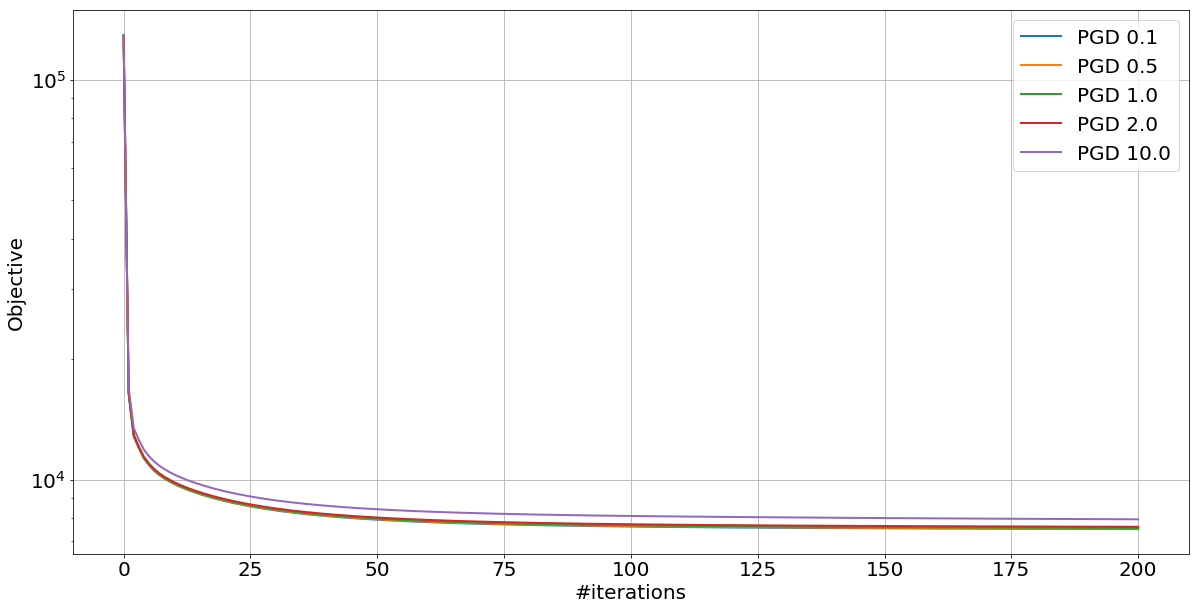

In [30]:
plt.figure(figsize=(20, 10))

for i in range(len(lams)):
    plt.plot(res_obj_list[i], label='PGD ' + str(lams[i]), linewidth=2.0)

plt.yscale("log")
#plt.xscale("log")
plt.legend(fontsize=20)
plt.xlabel("#iterations", fontsize=20)
plt.ylabel("Objective", fontsize=20)
plt.grid(True)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

In [48]:
N = 200
lams = [0.1, 0.5, 1.0, 2.0, 10.0]
res_obj_list = []
conv_X_list = []
conv_Z_list = []

for lam in lams:
    res_obj, res_X, w  = sub_alg(f_grad, X, y, lam=lam, w0=w0, num_iter=200, step=1e-4) 
    res_obj_list.append(res_obj)
    conv_X_list.append(res_X)
    print(lam)

0.1
0.5
1.0
2.0
10.0


(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225.]),
 <a list of 11 Text xticklabel objects>)

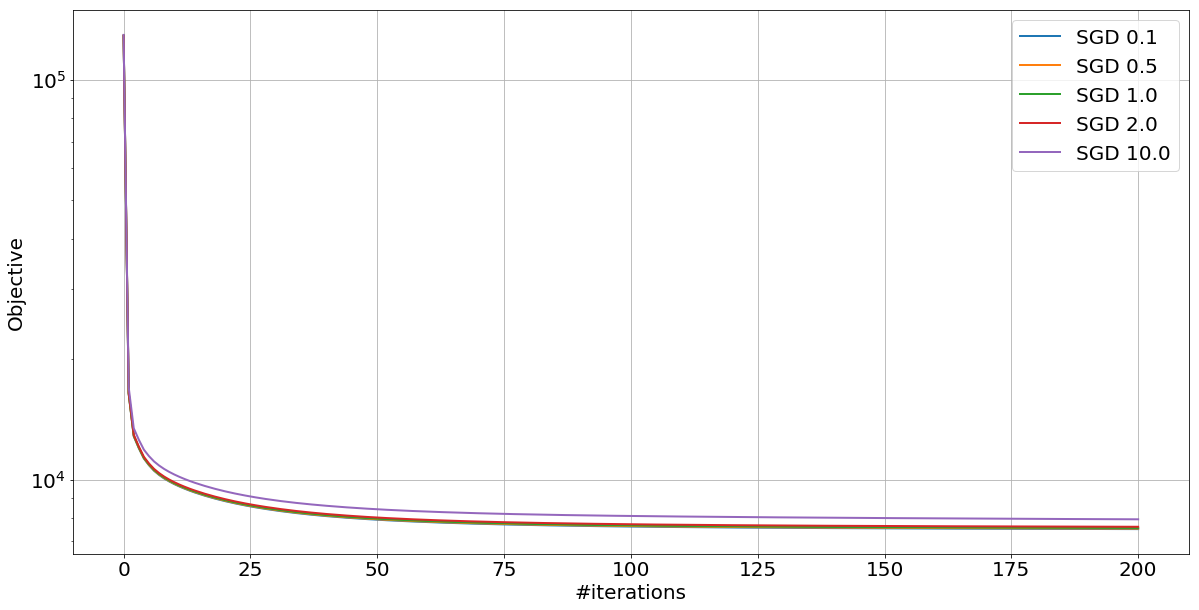

In [49]:
plt.figure(figsize=(20, 10))

for i in range(len(lams)):
    plt.plot(res_obj_list[i], label='SGD ' + str(lams[i]), linewidth=2.0)

plt.yscale("log")
#plt.xscale("log")
plt.legend(fontsize=20)
plt.xlabel("#iterations", fontsize=20)
plt.ylabel("Objective", fontsize=20)
plt.grid(True)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225.]),
 <a list of 11 Text xticklabel objects>)

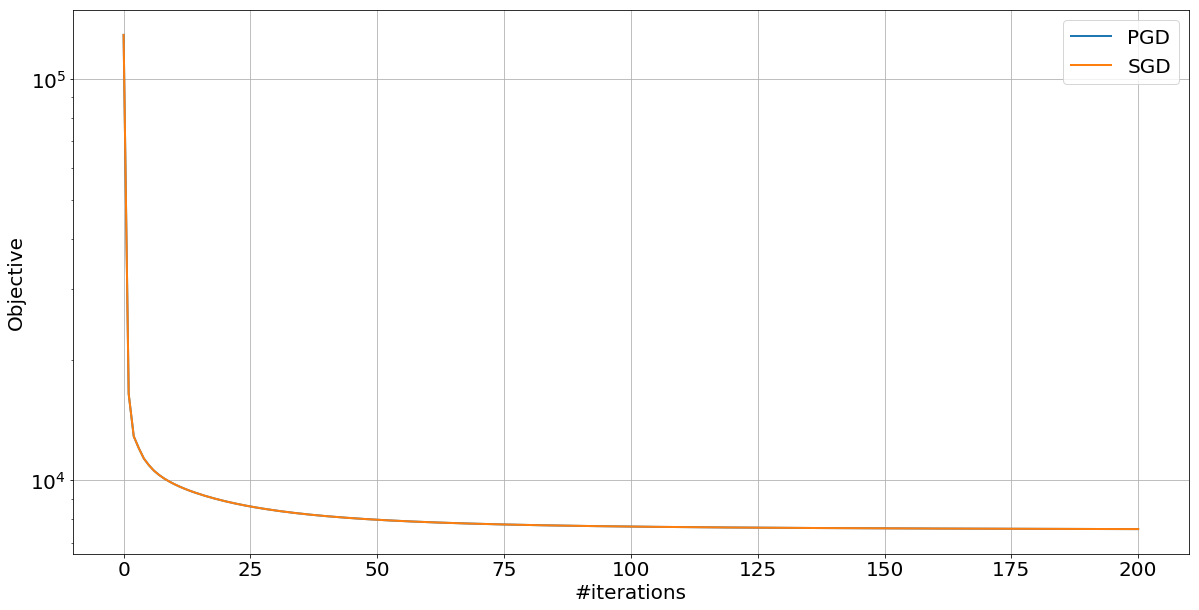

In [52]:
conv_obj_pgd, conv_w, w, derivatives = prox_alg(f_grad, g_prox, X, y, lam=1.0, w0=w0, num_iter=200, step=1e-4)
conv_obj_sub, conv_w, w = sub_alg(f_grad, X, y, lam=1.0, w0=w0, num_iter=200, step=1e-4)

plt.figure(figsize=(20, 10))

'''plt.plot(np.log(np.array(conv_obj_pgd)), label='PGD', linewidth=2.0)
plt.plot(np.log(np.array(conv_obj_sub)), label='SGD', linewidth=2.0)'''

plt.plot(conv_obj_pgd, label='PGD', linewidth=2.0)
plt.plot(conv_obj_sub, label='SGD', linewidth=2.0)

plt.yscale("log")
plt.legend(fontsize=20)
plt.xlabel("#iterations", fontsize=20)
plt.ylabel("Objective", fontsize=20)
plt.grid(True)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

Для этой конкретной задачи проксимальный и субградиентный спуски почти не отличаются (разница на каждой итерации около 1.0).